## Understanding and Predicting Property Maintenance Fines

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). 

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric chosen for this problem is the Area Under the ROC Curve (AUC). 

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import re
from scipy.sparse import hstack
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import Normalizer

In [33]:
df_train = pd.read_csv('train.csv',encoding = "ISO-8859-1")
df_test = pd.read_csv('test.csv')
print("Number of data points in train data", df_train.shape)

F:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (11,12,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of data points in train data (250306, 34)


In [34]:
print("The attributes of data :", df_train.columns.values)
df_train.head(2)

The attributes of data : ['ticket_id' 'agency_name' 'inspector_name' 'violator_name'
 'violation_street_number' 'violation_street_name' 'violation_zip_code'
 'mailing_address_str_number' 'mailing_address_str_name' 'city' 'state'
 'zip_code' 'non_us_str_code' 'country' 'ticket_issued_date'
 'hearing_date' 'violation_code' 'violation_description' 'disposition'
 'fine_amount' 'admin_fee' 'state_fee' 'late_fee' 'discount_amount'
 'clean_up_cost' 'judgment_amount' 'payment_amount' 'balance_due'
 'payment_date' 'payment_status' 'collection_status' 'grafitti_status'
 'compliance_detail' 'compliance']


,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0


In [35]:
print("The attributes of data :", df_test.columns.values)
df_test.head(2)

The attributes of data : ['ticket_id' 'agency_name' 'inspector_name' 'violator_name'
 'violation_street_number' 'violation_street_name' 'violation_zip_code'
 'mailing_address_str_number' 'mailing_address_str_name' 'city' 'state'
 'zip_code' 'non_us_str_code' 'country' 'ticket_issued_date'
 'hearing_date' 'violation_code' 'violation_description' 'disposition'
 'fine_amount' 'admin_fee' 'state_fee' 'late_fee' 'discount_amount'
 'clean_up_cost' 'judgment_amount' 'grafitti_status']


,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,...,Failure to secure City or Private solid waste ...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
1,285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,...,Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN


### Data Wrangling

In [36]:
df_train['compliance'].isnull().sum()

90426

In [37]:
X = df_train[df_train['compliance'].isnull()==False]
X_test = df_train[df_train['compliance'].isnull()==True]
# y_train = df_train[df_train['compliance'].isnull()==False].compliance
features = np.append(df_test.columns.values,['compliance'])
X = X[features]
X_test = X_test[features]
X.isnull().sum()

ticket_id                          0
agency_name                        0
inspector_name                     0
violator_name                     26
violation_street_number            0
violation_street_name              0
violation_zip_code            159880
mailing_address_str_number      2558
mailing_address_str_name           3
city                               0
state                             84
zip_code                           1
non_us_str_code               159877
country                            0
ticket_issued_date                 0
hearing_date                     227
violation_code                     0
violation_description              0
disposition                        0
fine_amount                        0
admin_fee                          0
state_fee                          0
late_fee                           0
discount_amount                    0
clean_up_cost                      0
judgment_amount                    0
grafitti_status               159880
c

In [38]:
# plt.box(on=X['mailing_address_str_name'])
# plt.show()

In [39]:
X = X.drop(labels=['zip_code','ticket_id','ticket_issued_date','violation_zip_code','grafitti_status','non_us_str_code','violator_name','hearing_date'],axis=1)
X = X[X['mailing_address_str_name'].isnull()==False]
X.mailing_address_str_number.fillna(value=np.random.choice(X.mailing_address_str_number.values),inplace=True)
X.state.fillna(value=X.state.value_counts().keys()[0],inplace=True)
X.isnull().sum()

agency_name                   0
inspector_name                0
violation_street_number       0
violation_street_name         0
mailing_address_str_number    0
mailing_address_str_name      0
city                          0
state                         0
country                       0
violation_code                0
violation_description         0
disposition                   0
fine_amount                   0
admin_fee                     0
state_fee                     0
late_fee                      0
discount_amount               0
clean_up_cost                 0
judgment_amount               0
compliance                    0
dtype: int64

In [26]:
def preprocess_feat(data):
    l = []
    for text in data:
        text = text.lower()
        text = text.replace('/','')
        text = text.replace(' ','_')
        text = text.replace('_','_')
        text = text.replace('.','')
        text = text.replace('&','_')
        text = text.replace('(','_')
        text = text.replace(')','_')
        text = text.replace(',','_')
        text = text.replace(' The ','')
        text = text.replace(';','')
        text = text.replace('-','')
        l.append(text)
    return l

In [27]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

# Combining all the above stundents 
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [40]:
num_feat = ['violation_street_number', 'mailing_address_str_number', 'fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount',
            'clean_up_cost', 'judgment_amount']
cat_feat = ['state' ,'violation_description' ,'city', 'country','violation_code' ,'violation_street_name', 'inspector_name',
            'disposition', 'agency_name', 'mailing_address_str_name']
print(cat_feat)
print(num_feat)

['state', 'violation_description', 'city', 'country', 'violation_code', 'violation_street_name', 'inspector_name', 'disposition', 'agency_name', 'mailing_address_str_name']
['violation_street_number', 'mailing_address_str_number', 'fine_amount', 'admin_fee', 'state_fee', 'late_fee', 'discount_amount', 'clean_up_cost', 'judgment_amount']


In [41]:
for f in cat_feat:
    if f != 'violation_description':
        X[f] = preprocess_feat(X[f])
X['violation_description'] = preprocess_text(X['violation_description'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159877/159877 [00:11<00:00, 14119.84it/s]


In [42]:
X.head()

,agency_name,inspector_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,country,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance
0,buildings__safety_engineering___env_department,sims__martinzie,2900.0,tyler,3.0,s_wicker,chicago,il,usa,9136_a_,failure owner obtain certificate compliance,responsible_by_default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0
1,buildings__safety_engineering___env_department,williams__darrin,4311.0,central,2959.0,martin_luther_king,detroit,mi,usa,61630600,failed secure permit lawful use building,responsible_by_determination,750.0,20.0,10.0,75.0,0.0,0.0,855.0,1.0
5,buildings__safety_engineering___env_department,sims__martinzie,6478.0,northfield,2755.0,e_17th,log_beach,ca,usa,9136_a_,failure owner obtain certificate compliance,responsible_by_default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0
6,buildings__safety_engineering___env_department,williams__darrin,8027.0,brentwood,476.0,garfield,clinton,mi,usa,61630500,failed secure permit lawful use land,responsible_by_default,750.0,20.0,10.0,75.0,0.0,0.0,855.0,0.0
7,buildings__safety_engineering___env_department,williams__darrin,8228.0,mt_elliott,8228.0,mt_elliott,detroit,mi,usa,61630100,noncompliance grant condition bza bse,responsible_by_default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0


In [43]:
X_test.index = X_test['ticket_id']
X_test = X_test[X.columns.values]
X_test.head(3)

,agency_name,inspector_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,country,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,compliance
ticket_id,,,,,,,,,,,,,,,,,,,,
22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",1449.0,LONGFELLOW,23658.0,P.O. BOX,DETROIT,MI,USA,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
22084,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",1441.0,LONGFELLOW,5.0,ST. CLAIR,DETROIT,MI,USA,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by City Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
22093,"Buildings, Safety Engineering & Env Department","Sims, Martinzie",2449.0,CHURCHILL,7449.0,CHURCHILL,DETROIT,MI,USA,9-1-36(a),Failure of owner to obtain certificate of comp...,Not responsible by Dismissal,250.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [44]:
X_test.mailing_address_str_number.fillna(value=np.random.choice(X_test.mailing_address_str_number.values),inplace=True)
X_test.state.fillna(value=X_test.state.value_counts().keys()[0],inplace=True)
X_test.mailing_address_str_name.fillna(value=X_test.mailing_address_str_name.value_counts().keys()[0],inplace=True)
X_test.fine_amount.fillna(value=X_test.fine_amount.min(),inplace=True)
X_test.isnull().sum()

agency_name                       0
inspector_name                    0
violation_street_number           0
violation_street_name             0
mailing_address_str_number        0
mailing_address_str_name          0
city                              0
state                             0
country                           0
violation_code                    0
violation_description             0
disposition                       0
fine_amount                       0
admin_fee                         0
state_fee                         0
late_fee                          0
discount_amount                   0
clean_up_cost                     0
judgment_amount                   0
compliance                    90426
dtype: int64

In [45]:
for f in cat_feat:
    if f != 'violation_description':
        X_test[f] = preprocess_feat(X_test[f])
X_test['violation_description'] = preprocess_text(X_test['violation_description'])
X_test = X_test.drop(labels='compliance',axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90426/90426 [00:06<00:00, 14259.22it/s]


In [46]:
y = X['compliance'].values
X = X.drop(labels='compliance',axis=1)

In [47]:
df_test.index = df_test['ticket_id']
df_test = df_test[X.columns.values]
df_test.mailing_address_str_number.fillna(value=np.random.choice(df_test.mailing_address_str_number.values),inplace=True)
# df_test.state.fillna(value=df_test.state.value_counts().keys()[0],inplace=True)
df_test.state.fillna(method='ffill',inplace=True)
df_test.mailing_address_str_name.fillna(value=df_test.mailing_address_str_name.value_counts().keys()[0],inplace=True)
df_test.city.fillna(value=df_test.city.value_counts().keys()[0],inplace=True)
df_test.isnull().sum()

agency_name                   0
inspector_name                0
violation_street_number       0
violation_street_name         0
mailing_address_str_number    0
mailing_address_str_name      0
city                          0
state                         0
country                       0
violation_code                0
violation_description         0
disposition                   0
fine_amount                   0
admin_fee                     0
state_fee                     0
late_fee                      0
discount_amount               0
clean_up_cost                 0
judgment_amount               0
dtype: int64

In [48]:
for f in cat_feat:
    if f != 'violation_description':
        df_test[f] = preprocess_feat(df_test[f])
        
df_test['violation_description'] = preprocess_text(df_test['violation_description'])
df_test.head(3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61001/61001 [00:05<00:00, 11934.73it/s]


,agency_name,inspector_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,country,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount
ticket_id,,,,,,,,,,,,,,,,,,,
284932,department_of_public_works,granberry__aisha_b,10041.0,roseberry,141,roseberry,detroit,mi,usa,22261,failure secure city private solid waste collec...,responsible_by_default,200.0,20.0,10.0,20.0,0.0,0.0,250.0
285362,department_of_public_works,lusk__gertrina,18520.0,evergreen,19136,glastonbury,detroit,mi,usa,22288_b_,allowing bulk solid waste lie accumulate premises,responsible_by_default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0
285361,department_of_public_works,lusk__gertrina,18520.0,evergreen,19136,glastonbury,detroit,mi,usa,22243,improper placement courville container collect...,responsible_by_default,100.0,20.0,10.0,10.0,0.0,0.0,140.0


### Encoding Categorical fetures

In [49]:
X_tr, X_cv, y_tr, y_cv = train_test_split(X, y, random_state = 0)
print(X_tr.shape,y_tr.shape)
print(X_cv.shape,y_cv.shape)
print(X_test.shape)

(119907, 19) (119907,)
(39970, 19) (39970,)
(90426, 19)


In [50]:
# Label Encoding
# for f in cat_feat:
#     if f != 'violation_description':
#         le_tr = LabelEncoder().fit(X_tr[f])
#         X_tr[f] = le_tr.transform(X_tr[f])
#         le_cv = LabelEncoder().fit(X_cv[f])
#         X_cv[f] = le_cv.transform(X_cv[f])
#         le_te = LabelEncoder().fit(X_test[f])
#         X_test[f] = le_te.transform(X_test[f])

In [51]:
# # Encoding violation_description using tfidf
tf_vect = TfidfVectorizer(min_df=10)
tf_vect.fit(X_tr['violation_description'].values)
X_tr_vd_tf = tf_vect.transform(X_tr['violation_description'].values)
X_cv_vd_tf = tf_vect.transform(X_cv['violation_description'].values)
X_test_vd_tf = tf_vect.transform(X_test['violation_description'].values)
df_test_vd_tf = tf_vect.transform(df_test['violation_description'].values)
print(X_tr_vd_tf.shape)

(119907, 265)


In [52]:
vect = CountVectorizer()
vect.fit(X_tr['agency_name'].values)
train_cat_an = vect.transform(X_tr['agency_name'].values)
cv_cat_an = vect.transform(X_cv['agency_name'].values)
test_cat_an = vect.transform(X_test['agency_name'].values)
dftest_cat_an = vect.transform(df_test['agency_name'].values)

In [53]:
vect1 = CountVectorizer()
vect1.fit(X_tr['inspector_name'].values)
train_cat_in = vect1.transform(X_tr['inspector_name'].values)
cv_cat_in = vect1.transform(X_cv['inspector_name'].values)
test_cat_in = vect1.transform(X_test['inspector_name'].values)
dftest_cat_an = vect.transform(df_test['agency_name'].values)

In [54]:
vect2 = CountVectorizer()
vect2.fit(X_tr['violation_street_name'].values)
train_cat_vsn = vect2.transform(X_tr['violation_street_name'].values)
cv_cat_vsn = vect2.transform(X_cv['violation_street_name'].values)
test_cat_vsn = vect2.transform(X_test['violation_street_name'].values)
dftest_cat_an = vect.transform(df_test['agency_name'].values)

In [55]:
vect3 = CountVectorizer()
vect3.fit(X_tr['mailing_address_str_name'].values)
train_cat_masn = vect3.transform(X_tr['mailing_address_str_name'].values)
cv_cat_masn = vect3.transform(X_cv['mailing_address_str_name'].values)
test_cat_masn = vect3.transform(X_test['mailing_address_str_name'].values)
dftest_cat_an = vect.transform(df_test['agency_name'].values)

In [56]:
vect4 = CountVectorizer()
vect4.fit(X_tr['disposition'].values)
train_cat_dis = vect4.transform(X_tr['disposition'].values)
cv_cat_dis = vect4.transform(X_cv['disposition'].values)
test_cat_dis = vect4.transform(X_test['disposition'].values)
dftest_cat_an = vect.transform(df_test['agency_name'].values)

In [57]:
vect5 = CountVectorizer()
vect5.fit(X_tr['state'].values)
train_cat_state = vect5.transform(X_tr['state'].values)
cv_cat_state = vect5.transform(X_cv['state'].values)
test_cat_state = vect5.transform(X_test['state'].values)
dftest_cat_an = vect.transform(df_test['agency_name'].values)

In [58]:
vect6 = CountVectorizer()
vect6.fit(X_tr['city'].values)
train_cat_city = vect6.transform(X_tr['city'].values)
cv_cat_city = vect6.transform(X_cv['city'].values)
test_cat_city = vect6.transform(X_test['city'].values)
dftest_cat_an = vect.transform(df_test['agency_name'].values)

In [59]:
vect7 = CountVectorizer()
vect7.fit(X_tr['violation_code'].values)
train_cat_vc = vect7.transform(X_tr['violation_code'].values)
cv_cat_vc = vect7.transform(X_cv['violation_code'].values)
test_cat_vc = vect7.transform(X_test['violation_code'].values)
dftest_cat_an = vect.transform(df_test['agency_name'].values)

In [60]:
vect8 = CountVectorizer()
vect8.fit(X_tr['country'].values)
train_cat_c = vect8.transform(X_tr['country'].values)
cv_cat_c = vect8.transform(X_cv['country'].values)
test_cat_c = vect8.transform(X_test['country'].values)
dftest_cat_an = vect.transform(df_test['agency_name'].values)

In [61]:
normalizer = Normalizer()

normalised_x = {}
normalised_y = {}
normalised_z = {}
normalised_test = {}
for f in num_feat:
    normalizer.fit(X_tr[f].values.reshape(1,-1))
    normalised_x[f] = normalizer.transform(X_tr[f].values.reshape(1,-1))
    normalised_y[f] = normalizer.transform(X_cv[f].values.reshape(1,-1))
    normalised_z[f] = normalizer.transform(X_test[f].values.reshape(1,-1))
#     normalised_test[f] = normalizer.transform(df_test[f].values.reshape(1,-1))

In [62]:
X_tr = hstack((X_tr_vd_tf, train_cat_an,train_cat_in,train_cat_vsn,train_cat_masn,train_cat_dis,train_cat_state,train_cat_city,
               train_cat_vc,train_cat_c,normalised_x[num_feat[0]].T,normalised_x[num_feat[1]].T,normalised_x[num_feat[2]].T,
               normalised_x[num_feat[3]].T,normalised_x[num_feat[4]].T,normalised_x[num_feat[5]].T,normalised_x[num_feat[6]].T,
               normalised_x[num_feat[7]].T,normalised_x[num_feat[8]].T)).tocsr()

print(X_tr.shape,y_tr.shape)

(119907, 24495) (119907,)


In [63]:
X_cv = hstack((X_cv_vd_tf, cv_cat_an,cv_cat_in,cv_cat_vsn,cv_cat_masn,cv_cat_dis,cv_cat_state,cv_cat_city,
               cv_cat_vc,cv_cat_c,normalised_y[num_feat[0]].T,normalised_y[num_feat[1]].T,normalised_y[num_feat[2]].T,
               normalised_y[num_feat[3]].T,normalised_y[num_feat[4]].T,normalised_y[num_feat[5]].T,normalised_y[num_feat[6]].T,
               normalised_y[num_feat[7]].T,normalised_y[num_feat[8]].T)).tocsr()


print(X_cv.shape,y_cv.shape)

(39970, 24495) (39970,)


In [64]:
X_te = hstack((X_test_vd_tf, test_cat_an,test_cat_in,test_cat_vsn,test_cat_masn,test_cat_dis,test_cat_state,test_cat_city,
               test_cat_vc,test_cat_c,normalised_z[num_feat[0]].T,normalised_z[num_feat[1]].T,normalised_z[num_feat[2]].T,
               normalised_z[num_feat[3]].T,normalised_z[num_feat[4]].T,normalised_z[num_feat[5]].T,normalised_z[num_feat[6]].T,
               normalised_z[num_feat[7]].T,normalised_z[num_feat[8]].T)).tocsr()
print(X_te.shape)

(90426, 24495)


In [66]:
X_test = hstack((df_test_vd_tf, dftest_cat_an,dftest_cat_in,dftest_cat_vsn,dftest_cat_masn,dftest_cat_dis,dftest_cat_state,
                dftest_cat_city,dftest_cat_vc,dftest_cat_c,normalised_test[num_feat[0]].T,normalised_test[num_feat[1]].T,
                normalised_test[num_feat[2]].T,normalised_test[num_feat[3]].T,normalised_test[num_feat[4]].T,
                normalised_test[num_feat[5]].T,normalised_test[num_feat[6]].T,normalised_test[num_feat[7]].T,normalised_test[num_feat[8]].T).tocsr()

print(X_test.shape)

In [67]:
rf = RandomForestClassifier(n_estimators = 10, max_depth = 5)
rf.fit(X_tr, y_tr)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

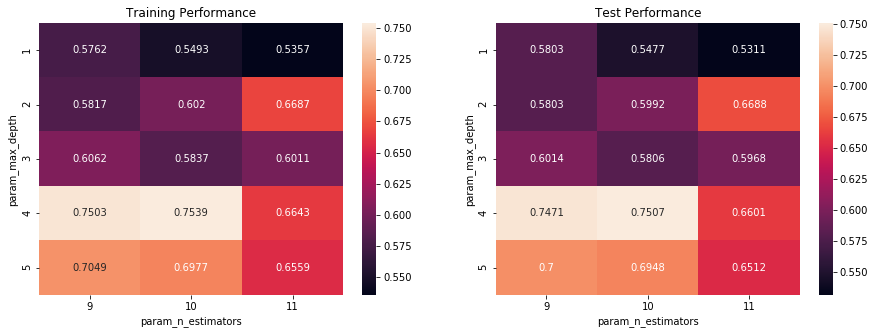

In [75]:
params = {'n_estimators': [9, 10, 11], 'max_depth': [1,2,3,4,5] }  # n_est = 10 and max_depth = 5
    
# default metric to optimize over grid parameters: accuracy
clf = GridSearchCV(rf, params, cv=3, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_tr)
results = pd.DataFrame.from_dict(clf.cv_results_)
r = results.pivot(index='param_max_depth', columns='param_n_estimators',values=['mean_train_score','mean_test_score'])
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(r.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(r.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Training Performance')
ax[1].set_title('Test Performance')
plt.show()

In [76]:
y_score = rf.predict(X_cv)    
fpr, tpr, thres = roc_curve(y_cv, y_score)

roc_auc = auc(fpr, tpr) 
print(roc_auc)

0.5


In [85]:
clf.best_params_,clf.best_score_

({'max_depth': 4, 'n_estimators': 10}, 0.7507126217621017)

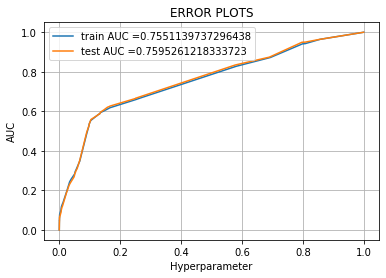

In [93]:
rfclf = RandomForestClassifier(max_depth=clf.best_params_['max_depth'], n_estimators=clf.best_params_['n_estimators'])
# rfclf = RandomForestClassifier(n_estimators = 10, max_depth = 5)
rfclf.fit(X_tr, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = rfclf.predict_proba(X_tr)    
y_cv_pred = rfclf.predict_proba(X_cv)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_tr, y_train_pred[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_cv, y_cv_pred[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [88]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.29971366780771935 for threshold 0.073


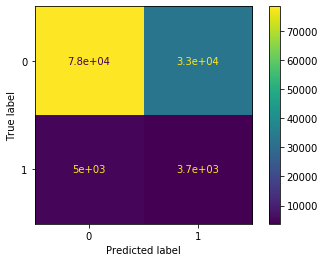

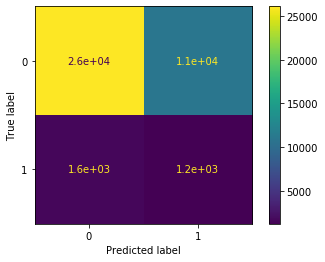

In [72]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

#finding confusion matrices for train and test data
cm_train = ConfusionMatrixDisplay(confusion_matrix(y_tr,predict_with_best_t(y_train_pred[:,1],best_t)),[0,1])
cm_test = ConfusionMatrixDisplay(confusion_matrix(y_cv,predict_with_best_t(y_cv_pred[:,1],best_t)),[0,1])

cm_train.plot()
cm_test.plot()

In [73]:
X_predict = rfclf.predict_proba(X_te)
X_predict

array([[0.9340501 , 0.0659499 ],
       [0.9340501 , 0.0659499 ],
       [0.9340501 , 0.0659499 ],
       ...,
       [0.93643849, 0.06356151],
       [0.93643849, 0.06356151],
       [0.93643849, 0.06356151]])

| Vectorizer | Model | Hyper parameters | AUC |
| :----------: |:-----:|:---------------:|:----:|
|TFIDF	     |DecisionTree|max_depth=10,min_samples_split=500	  |0.651|
|TFIDF W2V	 |DecisionTree|max_depth=10,min_samples_split=500   |0.633|
|Featurized TFIDF	 |LogisticRegression|C=1   |0.703|